# NWB conversion tutorial 

This Jupyter notebook contains a step-by-step tutorial on converting your NeuroPAL structural images and calcium activity time series to the NWB format and uploading to the DANDI archive. One NWB file will contain all of the raw data, processed data, and metadata associated with one trial of an experiment in one worm.

We will show examples of NWB conversion using datasets collected by Jackson Borchardt, Raymond Dunn, and Greg Bubnis in the FOCO lab at UCSF. These datasets have the raw neuroPAL and GCaMP data saved as tif files and neuron segmentation results as well as GCaMP quantification data saved as csv files. This tutorial will also work with data stored in different formats, but you may have to add some additional or different steps to load that data into the proper format for NWB files.

This tutorial should cover most basic applications of optical physiology in *C. elegans*. NWB can also flexibly incorporate many other types of data as well. See https://pynwb.readthedocs.io/en/stable/tutorials/index.html for documentation and tutorials on other types of data as well.

Please feel free to reach out to daniel.sprague@ucsf.edu with any questions or suggestions for changes.

### Imports and setup

Below are the necessary imports you need to work with your data and interface with NWB.

You will need to have a Python environment with the following packages installed: pynwb, skimage, numpy, hdmf, pandas, NWBinspector, Dandi, and ndx_multichannel_volume. You can also use the setup.py file found in the FOCO lab eats-worm repository on github https://github.com/focolab/eats-worm. This will include some additional packages to run our full processing pipeline, eats-worm, but will contain all of the packages necessary to do the NWB conversion. You will also need to run "ipython kernel install --user --name=*name of your environment*" within your virtual environment to use the environment in Jupyter notebook.

There are a number of python environment management platforms out there. Most people in our lab use anaconda https://docs.conda.io/projects/conda/en/stable/. 

If you have different file types or want to add additional types of data to your NWB file, you may need additional imports as well.

In [1]:
import os
from pynwb import load_namespaces, get_class
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
import skimage.io as skio
from collections.abc import Iterable
import numpy as np
from pynwb import register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
from hdmf.common import DynamicTable
from hdmf.utils import docval, get_docval, popargs, get_data_shape, popargs_to_dict
from hdmf.data_utils import DataChunkIterator
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from dateutil import tz
import pandas as pd
import scipy.io as sio
from datetime import datetime, timedelta
from tifffile import TiffFile
import matplotlib.pyplot as plt

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume

### Setting up the NWB file and adding basic metadata

In [2]:
'''
The NWBFile object is the base object which all other objects will be added to. This object holds 
metadata about the experiment, the specific trial, and the lab.

We show an example with the minimum metadata that should be included in any NWB file. Other optional
metadata fields can be found at https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile
'''

nwbfile = NWBFile(
    session_description = 'add a description for the experiment/session. can be just long form text',
    #Can use any identity marker that is specific to an individual trial. We use date-time to specify trials
    identifier = '20230322-21-41-10',
    #Specify date and time of trial. Datetime entries are in order Year, Month, Day, Hour, Minute, Second. Not all entries are necessary
    session_start_time = datetime(2023, 3, 22, 21, 41, 10, tzinfo=tz.gettz("US/Pacific")),
    lab = 'FOCO lab',
    institution = 'UCSF',
    related_publications = ''    
)

In [3]:
'''
The subject object is added onto the nwbfile object and contains the metadata associated with the subject of the
experiment. This should be the specific worm that you are using for this trial of the experiment.

Please reach out if there are other metadata fields that you think should be included here.
'''

nwbfile.subject = CElegansSubject(
    #This is the same as the NWBFile identifier for us, but does not have to be. It should just identify the subject for this trial uniquely.
    subject_id = '20230322-21-41-10',
    #Age is optional but should be specified in ISO 8601 duration format similarly to what is shown here for growth_stage_time
    #age = pd.Timedelta(hours=2, minutes=30).isoformat(),
    #Date of birth is a required field but if you do not know or if it's not relevant, you can just use the current date or the date of the experiment
    date_of_birth = datetime(2023, 3, 20, tzinfo=tz.gettz("US/Pacific")), 
    #Specify growth stage of worm - should be one of two-fold, three-fold, L1-L4, YA, OA, dauer, post-dauer L4, post-dauer YA, post-dauer OA
    growth_stage = 'YA',
    #Optional: specify time in current growth stage
    growth_stage_time=pd.Timedelta(hours=2, minutes=30).isoformat(),
    #Specify temperature at which animal was cultivated
    cultivation_temp = 20.,
    description = "free form text description, can include whatever you want here",
    #Currently using the ontobee species link until NWB adds support for C. elegans
    species  =  "http://purl.obolibrary.org/obo/NCBITaxon_6239",
    #Currently just using O for other until support added for other gender specifications
    sex = "O", 
    strain = "OH16230"
)

In [4]:
'''
The device object is where you specify the metadata of the type of microscope/data acquisition device
used. If there are multiple devices you are using, you can call nwbfile.create_device multiple times. 
Just make sure to give each device a different name and assign it to a different variable.

This device object will be attached to your data objects to show how they were acquired.
'''

device = nwbfile.create_device(
    name = "Spinning disk confocal",
    description = "Leica DMi8 Inverted Microscope with Yokagawa CSU-W1 SoRA, 40x WI objective 1.1 NA",
    manufacturer = "Leica, Yokagawa"
)

### Adding NeuroPAL images

In [5]:
'''
Here we define the ImagingVolume object. This object contains the metadata associated with the image acquisition including
the device used, the scale of the image in each dimension, and the excitation laser/emission filters/fluorophores used for 
each channel in the image.

You can create multiple ImagingVolume objects for each separate type of imaging data that you acquired. As with devices, just
make sure each ImagingVolume has a unique name and variable.
'''

#Channels is a list of tuples where each tuple contains the fluorophore used, the specific emission filter used, and a short description
#structured as "excitation wavelength-emission filter center point- width of emission filter in nm"
#Make sure this list is in the same order as the channels in your data
channels = [("mTagBFP2", "Chroma ET 460/50", "405-460-50m"), ("CyOFP1", "Chroma ET 605/70","488-605-70m"), ("CyOFP1-high filter", "Chroma ET 700/75","488-700-75m"), ("GFP-GCaMP", "Chroma ET 525/50","488-525-50m"), ("mNeptune 2.5", "Chroma ET 700/75", "561-700-75m"), ("Tag RFP-T", "Chroma ET 605/70", "561-605-70m"), ("mNeptune 2.5-far red", "Chroma ET 700/75", "639-700-75m")]


OptChannels = []
OptChanRefData = []
#The loop below takes the list of channels and converts it into a list of OpticalChannelPlus objects which hold the metadata
#for the optical channels used in the experiment
for fluor, des, wave in channels:
    excite = float(wave.split('-')[0])
    emiss_mid = float(wave.split('-')[1])
    emiss_range = float(wave.split('-')[2][:-1])
    OptChan = OpticalChannelPlus(
        name = fluor,
        description = des,
        excitation_lambda = excite,
        excitation_range = [excite-1.5, excite+1.5],
        emission_range = [emiss_mid-emiss_range/2, emiss_mid+emiss_range/2],
        emission_lambda = emiss_mid
    )

    OptChannels.append(OptChan)
    OptChanRefData.append(wave)


#This object just contains references to the order of channels because OptChannels does not retain the order alone
OpticalChannelRefs = OpticalChannelReferences(
    name = 'OpticalChannelRefs',
    channels = OptChanRefData
)

ImagingVol = ImagingVolume(
    name= 'ImagingVolume',
    #Add connections to the OptChannels and OpticalChannelRefs objects
    optical_channel_plus = OptChannels,
    Order_optical_channels = OpticalChannelRefs,
    #Free form description of what is being imaged in this volume
    description = 'NeuroPAL image of C. elegans brain',
    #Reference the device created earlier that was used to acquire this data
    device = device,
    #Specifies where in the C. elegans body the image is being taken of
    location = "Head",
    #Specifies the voxel spacing in x, y, z respectively. The values specified should be how many micrometers of physical
    #distance are covered by a single pixel in each dimension
    grid_spacing = [0.3208, 0.3208, 0.75],
    grid_spacing_unit = 'micrometers',
    #Origin coords, origin coords unit, and reference frames are carry over fields from other model organisms where you 
    #are likely only looking at a small portion of the brain. These fields are unfortunately required but feel free to put
    #whatever feels right here
    origin_coords = [0, 0, 0],
    origin_coords_unit = "micrometers",
    reference_frame = "Worm head"
)

In [6]:
'''
The next step is to create the MultiChannelVolume object which is where our volumetric images (e.g. NeuroPAL)
will be stored.

The data that is being stored here will be a 4D array: X, Y, Z, C. Each entry of the array will be the grey count
value for the pixel located at a specific X, Y, Z location in a specific channel.

We use tif files to store this data in our lab so the example here will be shown with tifs, but this can work 
with any file type that can be loaded and converted into a numpy array.

Make sure you know the order of the dimensions of your data when inputting here. The order should be X, Y, Z, C. We transpose
our data when loading because the data itself was not originally in that order. The channels must be the last dimension, but what
you define as X, Y, Z is somewhat arbitrary. For our imaging conditions, we define Z to be the slices and X, Y to refer to the 
dimensions of each slice. Then X is the longer of those two dimensions. It is up to you how you want to define these dimensions, 
just make sure that the order of the dimensions you choose is consistent with the order of dimensions for the pixel resolution you 
input here and the segmentation masks which we will define later.

Again, you can have any number of these images in one NWBfile, just make sure they are all named uniquely and that you provide
a reference to the correct Imaging Volume object for each image.
'''
raw_file = '/Users/danielysprague/foco_lab/data/NP_Ray/20230322-21-41-10/full_comp.tif'

#Data is in order C, Z, Y, X when reading in 
data = skio.imread(raw_file)
print(data.shape)
data = np.transpose(data)
print(data.shape)

RGBW_channels = [0,1,4,6]

Image = MultiChannelVolume(
    name = 'NeuroPALImageRaw',
    #This is the same OpticalChannelRefs used in the associated Imaging Volume
    Order_optical_channels = OpticalChannelRefs,
    #Specifies the voxel spacing in x, y, z respectively, same as in the Imaging Volume
    resolution = [0.3208, 0.3208, 0.75],
    description = 'free form description of image',
    #Specifies which channels in the image are associated with the RGBW channels - should be a list of channel indices as shown above
    RGBW_channels = RGBW_channels,
    #This is the raw data numpy array that we loaded above
    data = data,
    #This is a reference to the Imaging Volume object we defined previously
    imaging_volume = ImagingVol
)

(7, 48, 240, 1000)
(1000, 240, 48, 7)


In [7]:
'''
As an example of adding another image, I will also create an image object and associated image volume
for a version of the data that has undergone some basic pre-processing steps. Note that we create a new
imaging volume because this processed image only has 4 channels associated with the RGBW channels, so we
need a separate imaging volume to describe the order of the channels.
'''
processed_file = '/Users/danielysprague/foco_lab/data/NP_Ray/20230322-21-41-10/neuroPAL_image.tif'


proc_data = np.transpose(skio.imread(processed_file),[2,1,0,3])

print(proc_data.shape)

proc_channels = [channels[i] for i in RGBW_channels]

ProcOptChannels = []
ProcOptChanRefData = []
for fluor, des, wave in proc_channels:
    excite = float(wave.split('-')[0])
    emiss_mid = float(wave.split('-')[1])
    emiss_range = float(wave.split('-')[2][:-1])
    OptChan = OpticalChannelPlus(
        name = fluor,
        description = des,
        excitation_lambda = excite,
        excitation_range = [excite-1.5, excite+1.5],
        emission_range = [emiss_mid-emiss_range/2, emiss_mid+emiss_range/2],
        emission_lambda = emiss_mid
    )

    ProcOptChannels.append(OptChan)
    ProcOptChanRefData.append(wave)


ProcOpticalChannelRefs = OpticalChannelReferences(
    name = 'ProcOpticalChannelRefs',
    channels = ProcOptChanRefData
)

ProcImagingVol = ImagingVolume(
    name= 'ProcessedImagingVolume',
    optical_channel_plus = ProcOptChannels,
    Order_optical_channels = ProcOpticalChannelRefs,
    description = 'NeuroPAL image of C. elegans brain',
    device = device,
    location = "Head",
    grid_spacing = [0.3208, 0.3208, 0.75],
    grid_spacing_unit = 'micrometers',
    origin_coords = [0, 0, 0],
    origin_coords_unit = "micrometers",
    reference_frame = "Worm head"
)

ProcImage = MultiChannelVolume(
    name = 'ProcessedImage',
    Order_optical_channels = ProcOpticalChannelRefs,
    resolution = [0.3208, 0.3208, 0.75],
    description = 'Can describe the specific pre-processing steps taken here',
    RGBW_channels = [0,1,2,3],
    data = proc_data,
    imaging_volume = ProcImagingVol
)

(1000, 240, 48, 4)


### Adding segmentation and ID results

In [8]:
'''
Here we add the results of a neuron segmentation to the NWB file using the volume segmentation object. The process described here can be used to add other types of ROIs
as well. As before, just be sure to properly name and describe each of the 

There are two ways of doing this: using an image mask or a voxel mask. I will provide examples of both approaches here, but for the purposes of neuron segmentation, you 
would most likely be best off using the voxel mask approach. Note that each VolumeSegmentation object should have either an image mask or voxel mask and not both.

With image mask, each ROI will be represented by an array which is the same size as the original image where non-ROI voxels have value 0 and ROI voxels have non-zero value.
You should use image mask for ROIs which cover large portions of the image. For example, this would be useful if you were providing an ROI mask for where the body of the worm
is compared to background. Image mask does not currently support adding IDs to these ROIs, but we hope to add this functionality in soon.

With voxel mask, each ROI is represented by a list of voxels that belong to that ROI. Each entry in this list should have [x, y, z, weight, ID]. The weight should be a float value
which can have any meaning (i.e. could be the grey count of the voxel or a confidence level for that voxel being a member of that ROI). The ID can be the cell ID of the neuron ROI
or any other identity label. For a given ROI, each entry in the list should have the same value for ID. Please note in the description of the volume segmentation what the weight and 
ID categories mean in the object.

In the example files we use here, we are only segmenting for the center of neurons and not regions associated with each pixel. The volume segmentation works the same regardless of if 
you have single points or full masks.
'''

blob_file = '/Users/danielysprague/foco_lab/data/Manual_annotate/20230322-21-41-10/blobs.csv'
blobs = pd.read_csv(blob_file)

vs = VolumeSegmentation(
    name = 'VolumeSegmentation',
    description = 'Neuron centers for multichannel volumetric image. Weight set at 1 for all voxels. ID refers to cell ID of segmented neurons',
    #Reference the same ImagingVolume that your image was taken with
    imaging_volume = ImagingVol
)

#Uncomment the code below to use image_mask instead of voxel_mask
'''
for i, row in blobs.iterrows():
    #image_mask should have the same size as the x, y, z dimensions of the raw image
    image_mask = np.zeros(data.shape[:-1])
    x = row['X']
    y = row['Y']
    z = row['Z']
    ID = row['ID']

    #we define the ROI here as a 3x3x3 region surrounding the neuron center
    image_mask[x-1:x+1, y-1:y+1, z-1:z+1] = 1

'''

#Uncomment the code below to use voxel_mask instead of image_mask
for i, row in blobs.iterrows():
    voxel_mask = []
    x = row['X']
    y = row['Y']
    z = row['Z']
    ID = row['ID']

    voxel_mask.append([np.uint(x),np.uint(y),np.uint(z),1,str(ID)])

    vs.add_roi(voxel_mask=voxel_mask)


### Adding calcium imaging data

In [9]:
'''
Here we use the tifffile package to read in our calcium imaging tif files and examine the metadata contained in the file.
We see that there are 18000 pages, each with shape (240, 1000) which are associated with the YX dimensions. For our data,
each page represents a Z slice at a specific point in time. There are 12 Z slices per volume and 1500 time points
(1500*12=18000). 
'''

from tifffile import TiffFile

tif = TiffFile('/Users/danielysprague/foco_lab/data/NP_Ray/20230322-21-41-10/20230322-21-41-10.tiff')

print(len(tif.pages))

page = tif.pages[0]

print(page.shape)
print(page.dtype)
print(page.axes)

series = tif.series[0]
print(series.shape)
print(series.axes)

print(len(tif.pages))

tif.close()


18000
(240, 1000)
uint16
YX
(18000, 240, 1000)
QYX
18000


In [10]:
'''
If your calcium imaging data is relatively small (less than a few gigabytes) you may be able to just open your raw files and add the corresponding
data array to an NWB object in just the same way that we did for the NeuroPAL structural images. In practice, most calcium imaging data will be 
much larger than that and likely cannot be loaded all at once into memory. To solve this, we will have to do what's called an iterative data write.

In an iterative data write, we define a method to iteratively load portions of the larger data array and stitch them together in the NWB file. Once
we define the method for generating the data, NWB will handle the rest.

See https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html for optional fields to include in data objects here. All fields are specified using 
key word arguments in the object initialization. 
'''

#define a data generator function that will yield a single data entry, in our case we are iterating over time points and creating a Z stack of images for each time point
def iter_calc_tiff(filename, numZ):

    #TiffFile object allows you to access metadata for the tif file and selectively load individual pages/series
    tif = TiffFile(filename)

    #In this dataset, one page is one XY plane and every 12 pages comprises one Z stack for an individual time point
    pages = len(tif.pages)
    timepoints = int(pages/numZ)

    pageshape = tif.pages[0].shape

    #We iterate through all of the timepoints and yield each timepoint back to the DataChunkIterator
    for i in range(timepoints):
        tpoint = np.zeros((pageshape[1],pageshape[0], numZ))
        for j in range(numZ):
            image = np.transpose(tif.pages[i*numZ+j].asarray())
            tpoint[:,:,j] = image

        #Make sure array ends up as the correct dtype coming out of this function
        yield tpoint.astype('uint16')

    tif.close()

    return

#The DataChunkIterator wraps the data generator function and will stitch together the chunks as it iteratively reads over the full file
data = DataChunkIterator(
    data= iter_calc_tiff('/Users/danielysprague/foco_lab/data/NP_Ray/20230322-21-41-10/20230322-21-41-10.tiff', 12),
    #this will be the max shape of the final image. Can leave blank or set as the size of your full data if you know that ahead of time
    maxshape = None,
    buffer_size = 10,
)

optical_channel = OpticalChannel(
    name = 'GFP-GCaMP',
    description = 'GFP/GCaMP channel, 488 excitation, 525/50m emission',
    emission_lambda = 525.
)

imaging_plane = nwbfile.create_imaging_plane(
    name = 'CalciumImPlane',
    description = 'Imaging plane used to acquire calcium imaging data',
    optical_channel = optical_channel,
    device = device,
    excitation_lambda = 488.,
    indicator = 'GFP-GCaMP',
    location = 'Worm head',
    grid_spacing = [0.3208, 0.3208, 3],
    grid_spacing_unit = 'um',
    reference_frame = 'Worm head'
)

#Use OnePhotonSeries object to store calcium imaging series data
calcium_image_series = OnePhotonSeries(
    name="CalciumImageSeries",
    data=data,
    unit="n/a", 
    scan_line_rate = 0.5,
    dimension = [1000,240,12],
    rate = 4.0,
    imaging_plane = imaging_plane,
)

In [11]:
'''
Now that we have added our calcium imaging raw data to the NWB file, we can now add our processed calcium imaging data which consists
of ROI locations and fluorescence for each time point. 

To do this, we will be using the ImageSegmentation, PlaneSegmentation, Fluorescence, and ROIResponseSeries objects native to the Pynwb
OptoPhysiology spec.

Our calcium quantification data is stored in a CSV file with columns [Z, Y, X, T, blob_ix, ID, gce_quant]. We initially will convert that 
CSV file into a 3D numpy array with blob_ix on one dimension, time on another dimension, and X, Y, Z, ID, gce_quant on the final dimension.
'''

gce_quant = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_Ray/20230322-21-41-10/extractor-objects/20230322-21-41-10_gce_quantification.csv')

print(len(gce_quant['blob_ix'].unique())) #Count the number of unique blobs in this file
print(len(gce_quant['T'].unique())) #Count the number of unique time points in this file

quant = gce_quant[['X', 'Y', 'Z', 'gce_quant', 'ID', 'T', 'blob_ix']] #Reorder columns to order we want

blobquant = None
for idx in gce_quant['blob_ix'].unique():
    blob = quant[quant['blob_ix']==idx]
    blobarr = np.asarray(blob[['X','Y','Z','gce_quant','ID']]) 
    blobarr = blobarr[np.newaxis, :, :]
    if blobquant is None:
        blobquant=blobarr

    else:
        blobquant = np.vstack((blobquant, blobarr))

print(blobquant.shape) #Now dimensions are blob_ix, time, and data columns (X, Y, Z, gce_quant, ID). We are now ready to add this data to NWB objects.

planesegs = []

for t in range(blobquant.shape[1]):
    planeseg = PlaneSegmentation(
        name = 'Seg_tpoint_'+str(t),
        description = 'Neuron segmentation for time point ' +str(t) + ' in calcium image series',
        imaging_plane = imaging_plane,
        reference_images = calcium_image_series,
    )

    for i in range(blobquant.shape[0]):
        voxel_mask = blobquant[i,t,0:3] #X, Y, Z columns

        voxel_mask = np.hstack((voxel_mask, 1))
        voxel_mask = voxel_mask[np.newaxis,:]

        planeseg.add_roi(voxel_mask=voxel_mask)

    planesegs.append(planeseg)

ImSeg = ImageSegmentation(
    name = 'CalciumSeriesSegmentation',
    plane_segmentations = planesegs
)

gce_data = np.transpose(blobquant[:,:,3]) #Take only gce quantification column and transpose so time is in the first dimension

rt_region = planesegs[0].create_roi_table_region(
    description = 'All segmented neurons associated with calcium image series',
    region = list(np.arange(blobquant.shape[0]))
)

RoiResponse = RoiResponseSeries(
    #See https://pynwb.readthedocs.io/en/stable/pynwb.ophys.html#pynwb.ophys.RoiResponseSeries for additional key word argument options
    name = 'CalciumImResponseSeries',
    description = 'Fluorescence activity for calcium imaging data',
    data = gce_data,
    rois = rt_region,
    unit = '',
    rate = 4.0
)

fluor = Fluorescence(
    name = 'CalciumFluorTimeSeries',
    roi_response_series = RoiResponse
)

229
1500
(229, 1500, 5)


### Writing the NWB file

In [12]:
'''
Once we have created all the objects that we need to add to the NWB file, the next step is to actually add them to the file and then write the file to a specific location.

Objects are either put in the base acquisition module or in processing modules that users define. Only raw, acquired data should be put into the acquisition module, everything 
else should be put in processing modules. You can define any number of processing modules and add them to the base NWB file, but generally speaking each type of data that you
are adding to the file should have its own processing module. 
'''

#we add our raw NeuroPAL image to the acquisition module of the base NWB file
nwbfile.add_acquisition(Image)
nwbfile.add_acquisition(calcium_image_series)

#we create a processing module for our neuroPAL data 
neuroPAL_module = nwbfile.create_processing_module(
    name = 'NeuroPAL',
    description = 'NeuroPAL image data and metadata'
)

neuroPAL_module.add(vs)
neuroPAL_module.add(ImagingVol)
neuroPAL_module.add(OpticalChannelRefs)
neuroPAL_module.add(OptChannels)

#we create a processing module for the pre-processed neuroPAL image
processed_im_module = nwbfile.create_processing_module(
    name = 'ProcessedImage',
    description = 'Data and metadata associated with the pre-processed neuroPAL image.'
)

processed_im_module.add(ProcImage)
processed_im_module.add(ProcOpticalChannelRefs)
processed_im_module.add(ProcOptChannels)
processed_im_module.add(ProcImagingVol)

calcium_im_module = nwbfile.create_processing_module(
    name = 'CalciumActivity',
    description = 'Data and metadata associated with time series of calcium images'
)

calcium_im_module.add(ImSeg)
calcium_im_module.add(fluor)

#each NWB file should be named with a unique identifier 
identifier = '20230322-21-41-10'

#specify the file path you want to save this NWB file to 
io = NWBHDF5IO('/Users/danielysprague/foco_lab/data/NWB_tutorial/'+identifier+'.nwb', mode='w')
io.write(nwbfile)
io.close()

/Applications/anaconda3/envs/NWB/lib/python3.11/site-packages/hdmf/build/objectmapper.py:259: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/NWB/lib/python3.11/site-packages/hdmf/build/objectmapper.py:259: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/NWB/lib/python3.11/site-packages/hdmf/build/objectmapper.py:259: DtypeConversionWarning: Spec 'ImagingPlane/grid_spacing': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


### Reading from existing NWB files

In [13]:
'''
You read NWB files using the same NWBHDF5IO package that was used to write files. 

You can print the entire nwb file to see the contents of the file, including all modules and 
objects present. Each object will be shown in the field as the 'name' field that you assigned 
to that object when creating it. 

NWBHDF5IO does what is called a lazy read. This means when you load the object, it does not 
actually load the whole object into memory. You have to specify specific slices of the data to load.

In the example below we add [:] at the end of the variable declaration to indicate that we want to load
the entirety of that object into the variable. We could also select specific slices of that data.
For example, if we wanted to only load the first 4 channels of one Z slice of the raw neuroPAL data we
could do this by calling read_nwbfile.acquisition['NeuroPALImageRaw].data[:,:,12,0:4]. This indexing 
means we take all of the first two dimensions, the 13th slice of the third dimension (python indexing starts from 0),
and the first 4 slices of the last dimension (the channels). 

This lazy read is especially helpful when working with very large data, like calcium imaging data, because
it allows us to iteratively read in segments of that large data instead of having to load it into memory
all at once. 

'''

identifier = '20230322-21-41-10'

with NWBHDF5IO('/Users/danielysprague/foco_lab/data/NWB_tutorial/'+identifier+'.nwb', mode='r', load_namespaces=True) as io:
    read_nwbfile = io.read()
    print(read_nwbfile) # you can print the nwbfile after reading to see the contents of the file
    print(read_nwbfile.processing['CalciumActivity'])
    print(read_nwbfile.processing['NeuroPAL'])
    print(read_nwbfile.processing['ProcessedImage'])
    subject = read_nwbfile.subject #get the metadata about the experiment subject
    growth_stage = subject.growth_stage
    image = read_nwbfile.acquisition['NeuroPALImageRaw'].data[:] #get the neuroPAL image as a np array
    resolution = read_nwbfile.acquisition['NeuroPALImageRaw'].resolution[:] #get the resolution of the image in um/pixels
    channels = read_nwbfile.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    seg = read_nwbfile.processing['NeuroPAL']['VolumeSegmentation'].voxel_mask[:] #get the locations of neuron centers
    im_vol = read_nwbfile.processing['NeuroPAL']['ImagingVolume'] #get the metadata associated with the imaging acquisition
    optchans = read_nwbfile.processing['NeuroPAL']['ImagingVolume'].optical_channel_plus[:] #get information about all of the optical channels used in acquisition
    chan_refs = read_nwbfile.processing['NeuroPAL']['OpticalChannelRefs'].channels[:] #get the order of the optical channels in the image
    proc_image = read_nwbfile.processing['ProcessedImage']['ProcessedImage'].data[:] #get the pre-processed image
    calcium_frames = read_nwbfile.acquisition['CalciumImageSeries'].data[0:15, :,:,:] #load the first 15 frames of the calcium images
    fluor = read_nwbfile.processing['CalciumActivity']['CalciumFluorTimeSeries']['CalciumImResponseSeries'].data[:]


root pynwb.file.NWBFile at 0x12629238288
Fields:
  acquisition: {
    CalciumImageSeries <class 'pynwb.ophys.OnePhotonSeries'>,
    NeuroPALImageRaw <class 'ndx_multichannel_volume.ndx_multichannel_volume.MultiChannelVolume'>
  }
  devices: {
    Spinning disk confocal <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2023, 7, 13, 13, 33, 2, 377620, tzinfo=tzoffset(None, -25200))]
  identifier: 20230322-21-41-10
  imaging_planes: {
    CalciumImPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: UCSF
  lab: FOCO lab
  processing: {
    CalciumActivity <class 'pynwb.base.ProcessingModule'>,
    NeuroPAL <class 'pynwb.base.ProcessingModule'>,
    ProcessedImage <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['']
  session_description: add a description for the experiment/session. can be just long form text
  session_start_time: 2023-03-22 21:41:10-07:00
  subject: subject abc.CElegansSubject at 0x5317173328
Fields:
  age__reference: birth

(1000, 240, 48, 4)
(1000, 240, 48, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


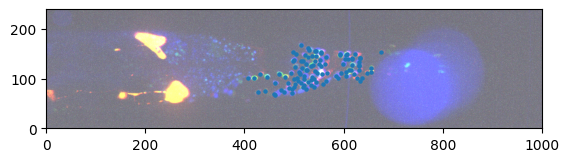

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


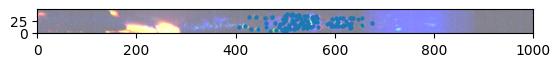

In [14]:
'''
Now that we've read in our objects from our NWB file, we can run analyses and create visualizations with
the data we have. Here I will show an example of displaying XZ and XY projections of the processed neuroPAL 
image and overlaying the segmented neuron centers on top.

Ideally, you could embed NWB into your full data processing pipeline, saving all of your raw and intermediary
data to the NWB file and reading objects directly from it as well. This eliminates the need to interface with 
almost any additional file types in your pipeline.
'''

blobs = pd.DataFrame.from_records(seg, columns = ['X', 'Y', 'Z', 'weight', 'ID'])
blobs = blobs.drop(['weight'], axis=1)
blobs = blobs.replace('nan', np.nan, regex=True) 

print(proc_image.shape)

RGB = proc_image[:,:,:,:-1]

print(RGB.shape)

Zmax = np.max(RGB, axis=2)
Ymax = np.max(RGB, axis=1)

plt.figure()

plt.imshow(np.transpose(Zmax, [1,0,2]))
plt.scatter(blobs['x'], blobs['y'], s=5)
plt.xlim((0, Zmax.shape[0]))
plt.ylim((0, Zmax.shape[1]))
plt.gca().set_aspect('equal')

plt.show()

plt.figure()

plt.imshow(np.transpose(Ymax, [1,0,2]))
plt.scatter(blobs['x'], blobs['z'], s=5)
plt.xlim((0, Ymax.shape[0]))
plt.ylim((0, Ymax.shape[1]))
plt.gca().set_aspect('equal')

plt.show()

### Editing existing NWB file

In [15]:
'''
You can flexibly add or remove objects from NWB files without having to completely rewrite the whole file.
See https://pynwb.readthedocs.io/en/stable/tutorials/general/add_remove_containers.html#sphx-glr-tutorials-general-add-remove-containers-py
for a tutorial on adding and removing objects.

Adding new objects is fairly straightforward. You just need to open the file, add new objects you create, and then rewrite the file todisk.

Removing objects is also fairly straightforward, but be careful you do not accidentally delete objects that are referenced by other objects
in the file. 
'''

'\nYou can flexibly add or remove objects from NWB files without having to completely rewrite the whole file.\nSee https://pynwb.readthedocs.io/en/stable/tutorials/general/add_remove_containers.html#sphx-glr-tutorials-general-add-remove-containers-py\nfor a tutorial on adding and removing objects.\n\nAdding new objects is fairly straightforward. You just need to open the file, add new objects you create, and then rewrite the file todisk.\n\nRemoving objects is also fairly straightforward, but be careful you do not accidentally delete objects that are referenced by other objects\nin the file. \n'